## Noise Added Speech Dataset

SNR = 10log(RMS_Signal^2/RMS_Noise^2)

=> RMS_Noise = sqrt(RMS_Signal^2 / 10^(SNR/10))

In [1]:
# Import
import librosa
import librosa.display
import soundfile as sf
import numpy as np
from math import sqrt
import IPython.display as ipd
import matplotlib.pyplot as plt

print('Librosa {}'.format(librosa.__version__))

# Sample Files
female_speech_file = "Audio Samples/Female_Speech.WAV"
male_speech_file = "Audio Samples/Male_Speech.WAV"
kindergarden_noise_file = "Audio Samples/Kindergarten_Noise.wav"
trainstation_noise_file = "Audio Samples/TrainStation_Noise.wav"

def add_noise_to_speech(speech, noise, snr, sampling_rate):

    # Load Speech and Noise
    org_speech, _ = librosa.load(speech, sr=sampling_rate)
    noise, _ = librosa.load(noise, sr=sampling_rate)

    concat_speech = org_speech

    # while len(concat_speech) < len(noise):
    #     if len(concat_speech) + len(org_speech) <= len(noise):
    #         concat_speech = np.concatenate((concat_speech, org_speech))
    #     else:
    #         break

    noise = noise[:len(concat_speech)]

    rms_speech = sqrt(np.mean(concat_speech ** 2))
    rms_noise_req = sqrt(rms_speech ** 2/pow(10, snr/10))

    rms_noise = sqrt(np.mean(noise ** 2))
    noise_mod = noise * (rms_noise/rms_noise_req)

    return concat_speech + noise_mod, concat_speech


Librosa 0.8.0


In [2]:
SAMPLING_RATE = 22050
SNR = 10

speech_noise_1, speech_clean = add_noise_to_speech(female_speech_file, kindergarden_noise_file,
                                     sampling_rate=SAMPLING_RATE, snr=SNR)

SNR = 0
speech_noise_2, _ = add_noise_to_speech(female_speech_file, kindergarden_noise_file,
                                     sampling_rate=SAMPLING_RATE, snr=SNR)

SNR = -5
speech_noise_3, _ = add_noise_to_speech(female_speech_file, kindergarden_noise_file,
                                     sampling_rate=SAMPLING_RATE, snr=SNR)

# ipd.Audio(speech_noise_3, rate=SAMPLING_RATE)

# plt.figure(figsize=(18, 5))
# plt.plot(speech_clean)
#
# plt.figure(figsize=(18, 5))
# plt.plot(speech_noise_1)

## Melband Gain

/home/abish/Documents/Project/Speech Enhancement Model/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/abish/Documents/Project/Speech Enhancement Model/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


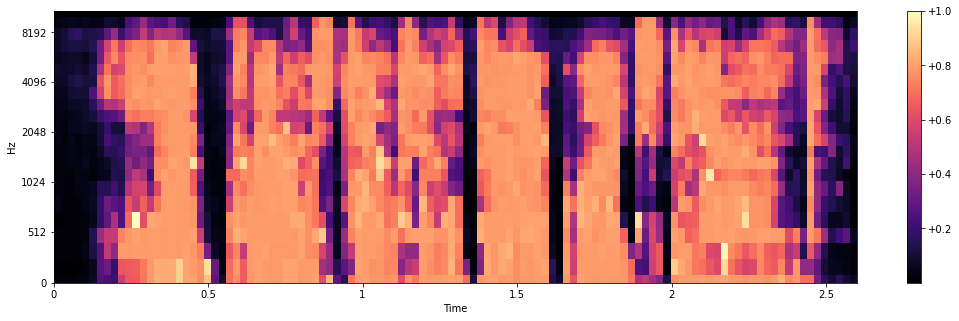

In [3]:
def get_melbands_gain(clean_speech, noisy_speech):

    clean_stft = (np.abs(librosa.stft(clean_speech, win_length=1024, hop_length=512,
                              n_fft=1024))) ** 2
    noisy_stft = (np.abs(librosa.stft(noisy_speech, win_length=1024, hop_length=512,
                              n_fft=1024))) ** 2


    # clean_mel = librosa.feature.melspectrogram(y=clean_speech, sr=22050, n_mels=22, power=2,
    #                                            win_length=1024, n_fft=1024, hop_length=512)
    # noisy_mel = librosa.feature.melspectrogram(y=noisy_speech, sr=22050, n_mels=22, power=2,
    #                                            win_length=1024, n_fft=1024, hop_length=512)

    clean_mel = librosa.feature.melspectrogram(S=clean_stft, sr=22050, n_mels=22,
                                               win_length=1024, n_fft=1024, hop_length=512)
    noisy_mel = librosa.feature.melspectrogram(S=noisy_stft, sr=22050, n_mels=22,
                                               win_length=1024, n_fft=1024, hop_length=512)

    # clean_mel_power = librosa.power_to_db(clean_mel)
    # noisy_mel_power = librosa.power_to_db(noisy_mel)


    gains_speech = np.sqrt(np.divide(clean_mel, noisy_mel))
    # gains_speech = np.where(gains_speech <= 0.01, 0.01, gains_speech)
    gains_speech = np.divide(gains_speech, np.max(gains_speech))

    plt.figure(figsize=(18,5))
    librosa.display.specshow(data=gains_speech, sr=22050, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+.1f")
    plt.show()


    return clean_mel, noisy_mel, gains_speech


a1_clean_mel, a1_noise_mel, a1_speech_gain = get_melbands_gain(clean_speech=speech_clean, noisy_speech=speech_noise_1)


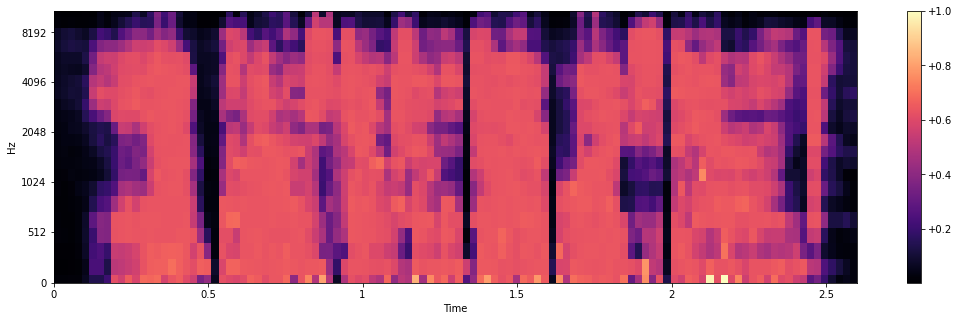

In [4]:
# Using Python Speech Features Library
from python_speech_features import fbank

a2_clean_psf, a2_clean_energy_psf = fbank(signal=speech_clean, nfft=1024,
                                      samplerate=22050, winlen=0.046,
                                      winstep=0.023, nfilt=22)
a2_noisy_psf, a2_noisy_energy_psf = fbank(signal=speech_noise_1, nfft=1024,
                                    samplerate=22050, winlen=0.046,
                                    winstep=0.023, nfilt=22)

a2_speech_gain_psf = (np.sqrt(np.divide(a2_clean_psf, a2_noisy_psf)))

a2_speech_gain_psf = np.divide(a2_speech_gain_psf, np.max(a2_speech_gain_psf)).T

plt.figure(figsize=(18,5))
librosa.display.specshow(data=a2_speech_gain_psf, sr=22050, x_axis="time", y_axis="mel")
plt.colorbar(format="%+.1f")
plt.show()

## VAD

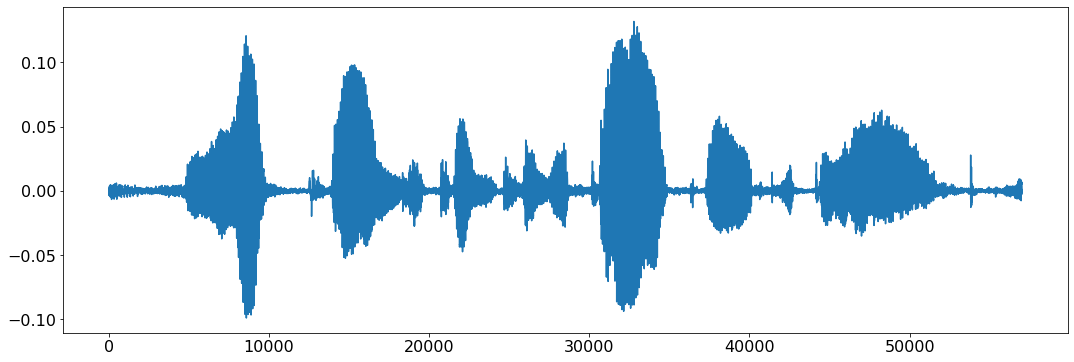

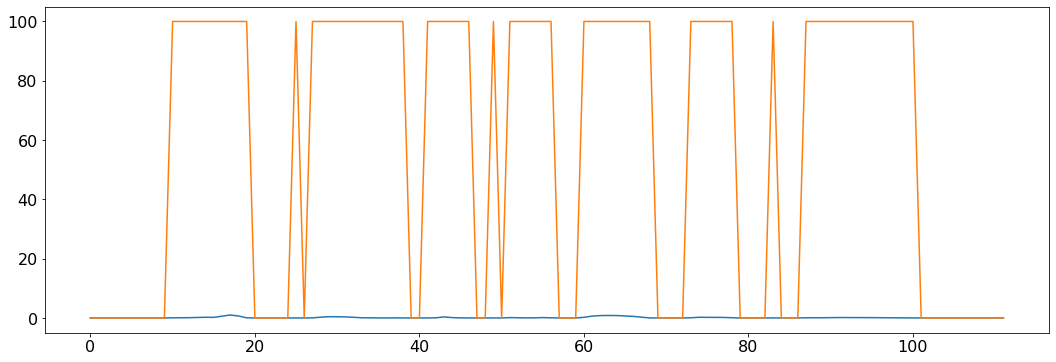

In [5]:
sampling_rate = 22050
frame_length = 1024
hop_length = 512
window_length = 1024
window_function = "vorbis"

from audio_utilities import FeatureExtraction

extract_features = FeatureExtraction(sampling_rate=sampling_rate,
                                     frame_length=frame_length, hop_length=hop_length,
                                     window_length=window_length, window_function=window_function)

def voice_activity_detection(clean_speech):

    # signal_magnitude = np.abs(clean_speech)
    # signal_voiced_flag = []
    #
    # for i in range(0, signal_magnitude.shape[0]):
    #     if signal_magnitude[i] > 0.01:
    #         signal_voiced_flag.append(True)
    #     else:
    #         signal_voiced_flag.append(False)
    #
    # return signal_magnitude, np.array(signal_voiced_flag)

    clean_speech_stft = extract_features.stft(audio=clean_speech, visualize=False)

    magnitude_spectrum = np.abs(clean_speech_stft) ** 2
    energy_per_frame = np.sum(magnitude_spectrum, axis=0)

    energy_per_frame = np.divide(energy_per_frame, np.max(energy_per_frame))

    clean_speech_mel_spectrogram = extract_features.get_melspectrogram(audio_stft=clean_speech_stft,
                                                                       number_of_melbands=22,
                                                                       visualize=False)

    energy_speech = librosa.feature.rms(S=clean_speech_stft, frame_length=frame_length,
                                        hop_length=hop_length)

    energy_speech_flags = []

    for i in range(0, magnitude_spectrum.shape[1]):
        if energy_per_frame[i] > 0.01:
            energy_speech_flags.append(True)
            # if i > 0:
            #     energy_speech_flags[i-1] = True
        else:
            energy_speech_flags.append(False)

    return energy_speech, energy_per_frame, np.array(energy_speech_flags)


signal_magnitude, energy, energy_flags = voice_activity_detection(speech_clean)

plt.figure(figsize=(18,6))
plt.plot(speech_noise_1)

plt.figure(figsize=(18,6))
plt.plot(energy)
plt.plot(energy_flags*100)